# Hand Gesture Recognition: Neural Network Training and Evaluation

This notebook details the process of training and evaluating a neural network for hand gesture recognition. The primary goal is to build a robust classifier that can accurately identify different hand gestures from landmark data extracted using MediaPipe.

The process involves:
1.  **Loading Preprocessed Data**: We use datasets of hand landmarks generated by the `data_generation.ipynb` notebook.
2.  **Hyperparameter Tuning**: A systematic search is performed to find the optimal set of hyperparameters for our neural network model.
3.  **Model Training**: The model is trained on the landmark data.
4.  **Evaluation**: The trained model's performance is rigorously evaluated using various metrics and visualizations.
5.  **Saving the Best Model**: The best-performing model is saved for real-time inference in the main application.

### Table of Contents
1. [Setup and Dependencies](#setup)
2. [Model Training and Hyperparameter Tuning](#training)
3. [Performance Analysis of All Variants](#performance-analysis)
4. [In-Depth Evaluation of the Best Model](#evaluation)
5. [Conclusion](#conclusion)

<a id="setup"></a>
## 1. Setup and Dependencies

This section ensures that the environment is correctly configured to run the notebook. The following code cell installs all the necessary Python libraries listed in the `requirements.txt` file.

**How to Use:**
1.  Make sure you have Python and `pip` installed.
2.  Ensure the `requirements.txt` file is in the same directory as this notebook.
3.  Run the next cell to install all dependencies.

This notebook relies on data generated by `data_generation.ipynb`. If you haven't run it yet, please do so before proceeding.

In [ ]:
%pip install -r requirements.txt

<a id="training"></a>
## 2. Model Training and Hyperparameter Tuning

This is the core section of the notebook, where we train our gesture classifier. The process is designed to be robust and systematic, incorporating hyperparameter tuning to find the best model configuration.

### The Process

1.  **Load Configuration**: We start by loading application-wide settings from `app_config.json`, which includes paths to datasets and model artifacts, as well as the hyperparameter search space.
2.  **Load Datasets**: The training and validation datasets, which contain the hand landmarks and corresponding gesture IDs, are loaded from CSV files.
3.  **Hyperparameter Grid Search**: We define a grid of hyperparameters to explore. This includes different learning rates, dropout rates, batch sizes, and network architectures. The code iterates through every possible combination of these hyperparameters.
4.  **Train a Model for Each Combination**: For each set of hyperparameters, a new `GestureClassifier` is instantiated and trained. The training process uses the training data (`X_train`, `Y_train`) and evaluates performance on a validation set (`X_val`, `Y_val`) at the end of each epoch.
5.  **Evaluate and Record Performance**: After training, each model variant is evaluated against a separate evaluation dataset (`X_eval`, `Y_eval`). We calculate several regression and classification metrics to assess its performance, including:
    *   **R-squared ($R^2$)**: Measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s). An $R^2$ of 1 indicates that the model perfectly predicts the data.
    *   **Mean Squared Error (MSE)**: The average of the squares of the errors. It is sensitive to large errors. $MSE = \\frac{1}{N} \\sum_{i=1}^{N} (y_i - \\hat{y}_i)^2$
    *   **Mean Absolute Error (MAE)**: The average of the absolute differences between predictions and actual values. It is less sensitive to outliers than MSE. $MAE = \\frac{1}{N} \\sum_{i=1}^{N} |y_i - \\hat{y}_i|$
6.  **Identify and Save the Best Model**: After all variants have been trained and evaluated, we identify the best-performing model based on the highest validation R2-Score and lowest validation loss. This model is then saved to a file (`gesture_model.h5`) for use in the application. All performance metrics are saved to `models_performance.csv`.

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from src.gesture_controller.gesture_classifier import GestureClassifier
from src.gesture_controller.app_config import AppConfig
import itertools as itertools
import pandas as pd
import numpy as np
import sys
import os

# --- Load Configuration ---
config = AppConfig()
data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_train_path = data_generation_config.get("DATASET_TRAINING_PATH")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

model_path = config.get_neural_network_config().get('MODEL_PATH')
model_performance_path = config.get_neural_network_config().get('MODEL_PERFORMANCE_PATH')
hyperparam_config = config.get_hyperparameter_config()


# --- Load and Prepare Dataset ---
try:
    # Load training dataset from CSV
    df_train = pd.read_csv(datase_train_path)
    df_train['LANDMARKS'] = df_train['LANDMARKS'].apply(eval)
    X = np.array(df_train['LANDMARKS'].tolist())
    Y = df_train['GESTURE_ID']

    # Load validation/evaluation dataset from CSV
    df_eval = pd.read_csv(datase_val_path)
    df_eval['LANDMARKS'] = df_eval['LANDMARKS'].apply(eval)
    X_eval = np.array(df_eval['LANDMARKS'].tolist())
    Y_eval = df_eval['GESTURE_ID']

    # Dynamically determine number of classes based on highest gesture ID
    max_gesture_id = Y.max()
    num_classes = max_gesture_id + 1

    # Split the data into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # --- Hyperparameter Tuning ---
    hyperparam_keys = list(hyperparam_config.keys())
    hyperparam_values = list(hyperparam_config.values())

    # Generate all combinations
    hyperparam_combinations = list(itertools.product(*hyperparam_values))

    print(f"Total hyperparameter combinations: {len(hyperparam_combinations)}")

    training_history = []
    best_model = None
    best_val_accuracy = 0
    best_val_loss = float('inf')

    # Iterate over all hyperparameter combinations
    for i, params in enumerate(hyperparam_combinations):
        
        hyperparams = dict(zip(hyperparam_keys, params))
        
        print(f"--- Training Variant {i+1}/{len(hyperparam_combinations)} ---")
        print(f"Hyperparameters: {hyperparams}")
        
        # Create a new classifier for each hyperparameter combination
        classifier = GestureClassifier(num_classes=num_classes, input_size=X_train.shape[1], hyperparams=hyperparams)

        # Train the model
        model, history = classifier.train(
            X_train, Y_train, X_val, Y_val, 
            batch_size=hyperparams['BATCH_SIZE'], 
            epochs=hyperparams['EPOCHS']
        )

        Y_pred = classifier.evaluate(X_eval)

        score_training_val_accuracy = history.history['val_accuracy'][-1]
        score_training_val_loss = history.history['val_loss'][-1]
        score_val_r2 = r2_score(Y_eval, Y_pred)
        score_val_mse = mean_squared_error(Y_eval, Y_pred)
        score_val_mae = mean_absolute_error(Y_eval, Y_pred)
        score_val_mape = mean_absolute_percentage_error(Y_eval, Y_pred)
        
        print(f"R2 Score: {score_val_r2:.4f}")
        print(f"MSE: {score_val_mse:.4f}")
        print(f"MAE: {score_val_mae:.4f}")
        print(f"MAPE: {score_val_mape:.4f}")

        # Store history
        run_info = {
            'variant': i + 1,
            'hyperparameters': hyperparams,
            'val_accuracy': score_training_val_accuracy,
            'val_loss': score_training_val_loss,
            'val_r2': score_val_r2,
            'val_mse': score_val_mse,
            'val_mae': score_val_mae,
            'val_mape': score_val_mape,
            'history': history.history,
            'model': model
        }
        training_history.append(run_info)

    # Display results
    history_df = pd.DataFrame(training_history)
    history_df.to_csv(model_performance_path)

    best_run = min(training_history, key=lambda x: (1 - x['val_r2'], x['training_val_loss']))
    
    print("\n--- Best Model Found ---")
    print(f"Parameters: {best_run['hyperparameters']}")
    print(f"R2 Score: {best_run['val_r2']:.4f}")
    print(f"MSE: {best_run['val_mse']:.4f}")
    print(f"MAE: {best_run['val_mae']:.4f}")
    print(f"MAPE: {best_run['val_mape']:.4f}")
    
    best_run['model'].save(model_path)


except FileNotFoundError:
    print(f"Error: Dataset file not found at '{datase_train_path}'.")
    print("Please run the data generation notebook first.")
except Exception as e:
    print(f"An error occurred: {e}")

<a id="performance-analysis"></a>
## 3. Performance Analysis of All Variants

After training multiple model variants, it's crucial to analyze their performance to understand how different hyperparameters affect the outcome. This section visualizes the results stored in `models_performance.csv`.

### Interpreting the Plots

The following code cell will generate two key visualizations:

1.  **Validation Loss vs. R2 Score**: This scatter plot helps us identify the best models. An ideal model is located in the **top-left corner**, indicating both low validation loss (high accuracy) and a high R2 score (goodness of fit).
2.  **Validation Loss by Hyperparameter**: These box plots show the distribution of validation loss for each hyperparameter we tested (e.g., activation function, dropout rate, learning rate). This allows us to see which hyperparameter choices lead to better (lower) and more consistent loss values. For example, we can compare if `relu` or `tanh` activation functions, on average, result in better model performance.

These visualizations provide a high-level overview of the hyperparameter search and guide the selection of the best model.

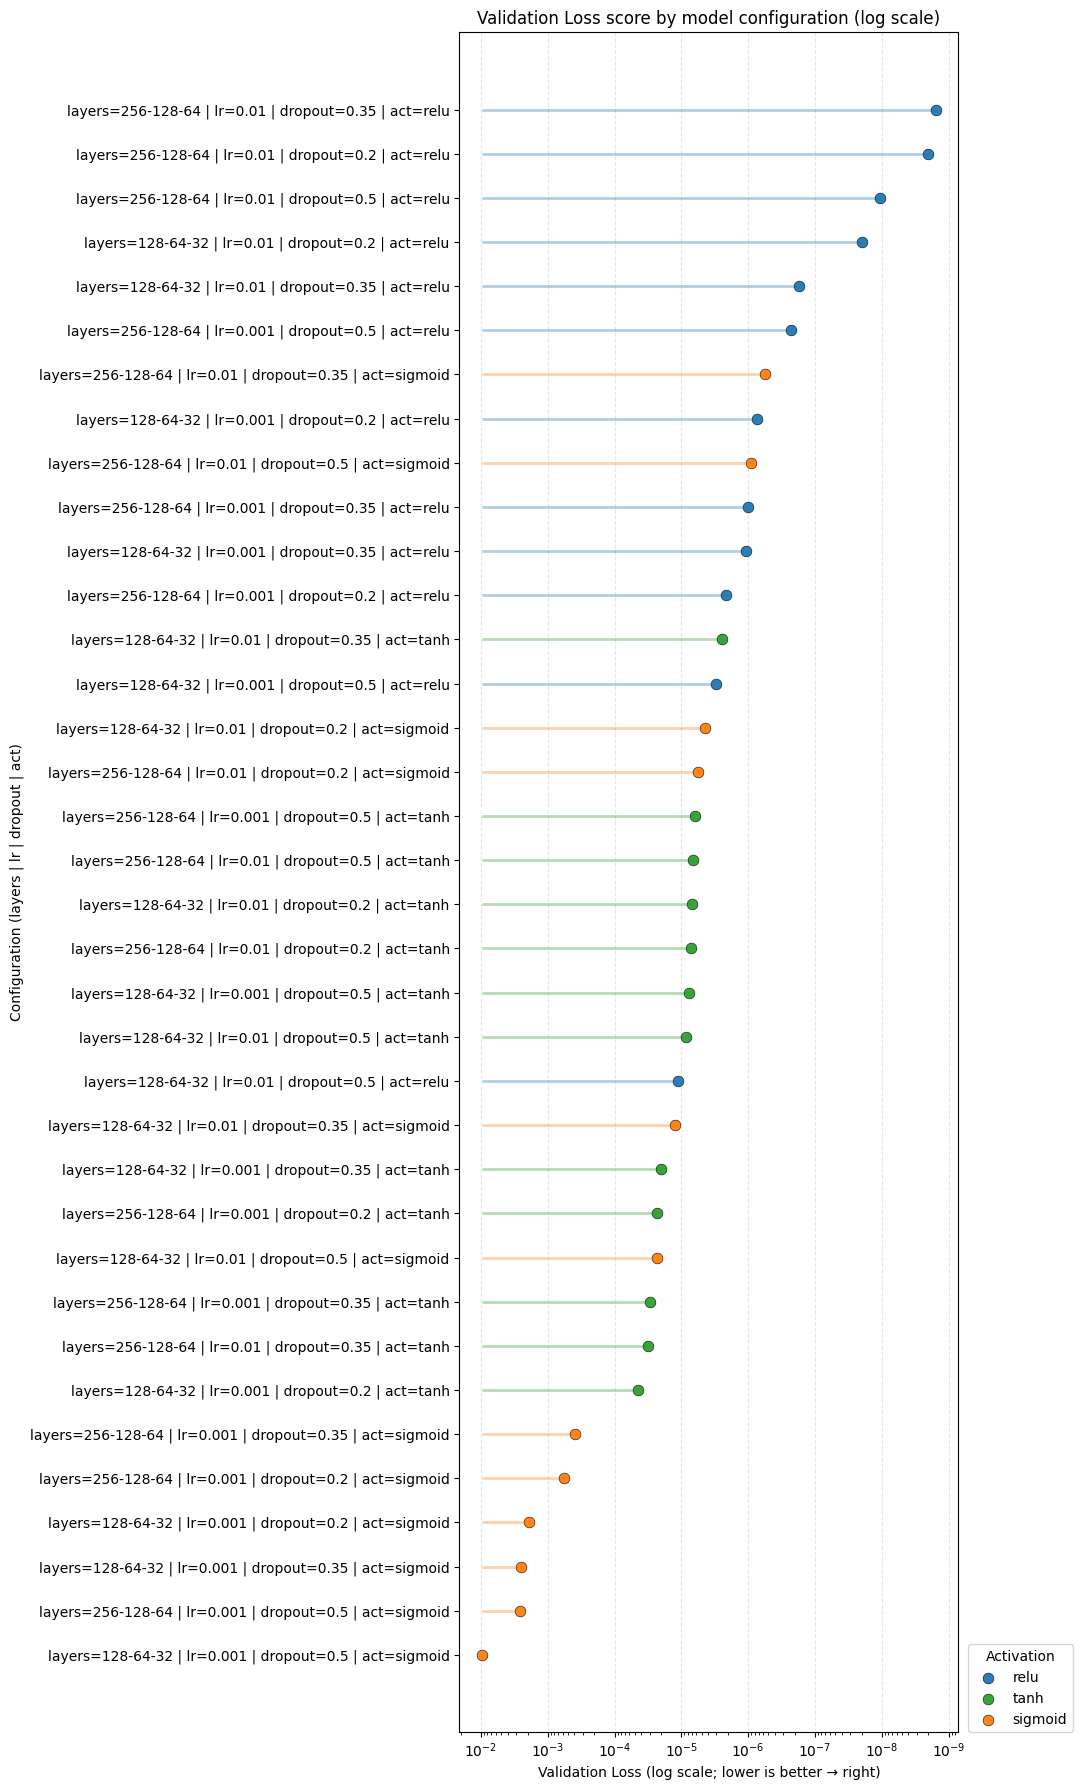

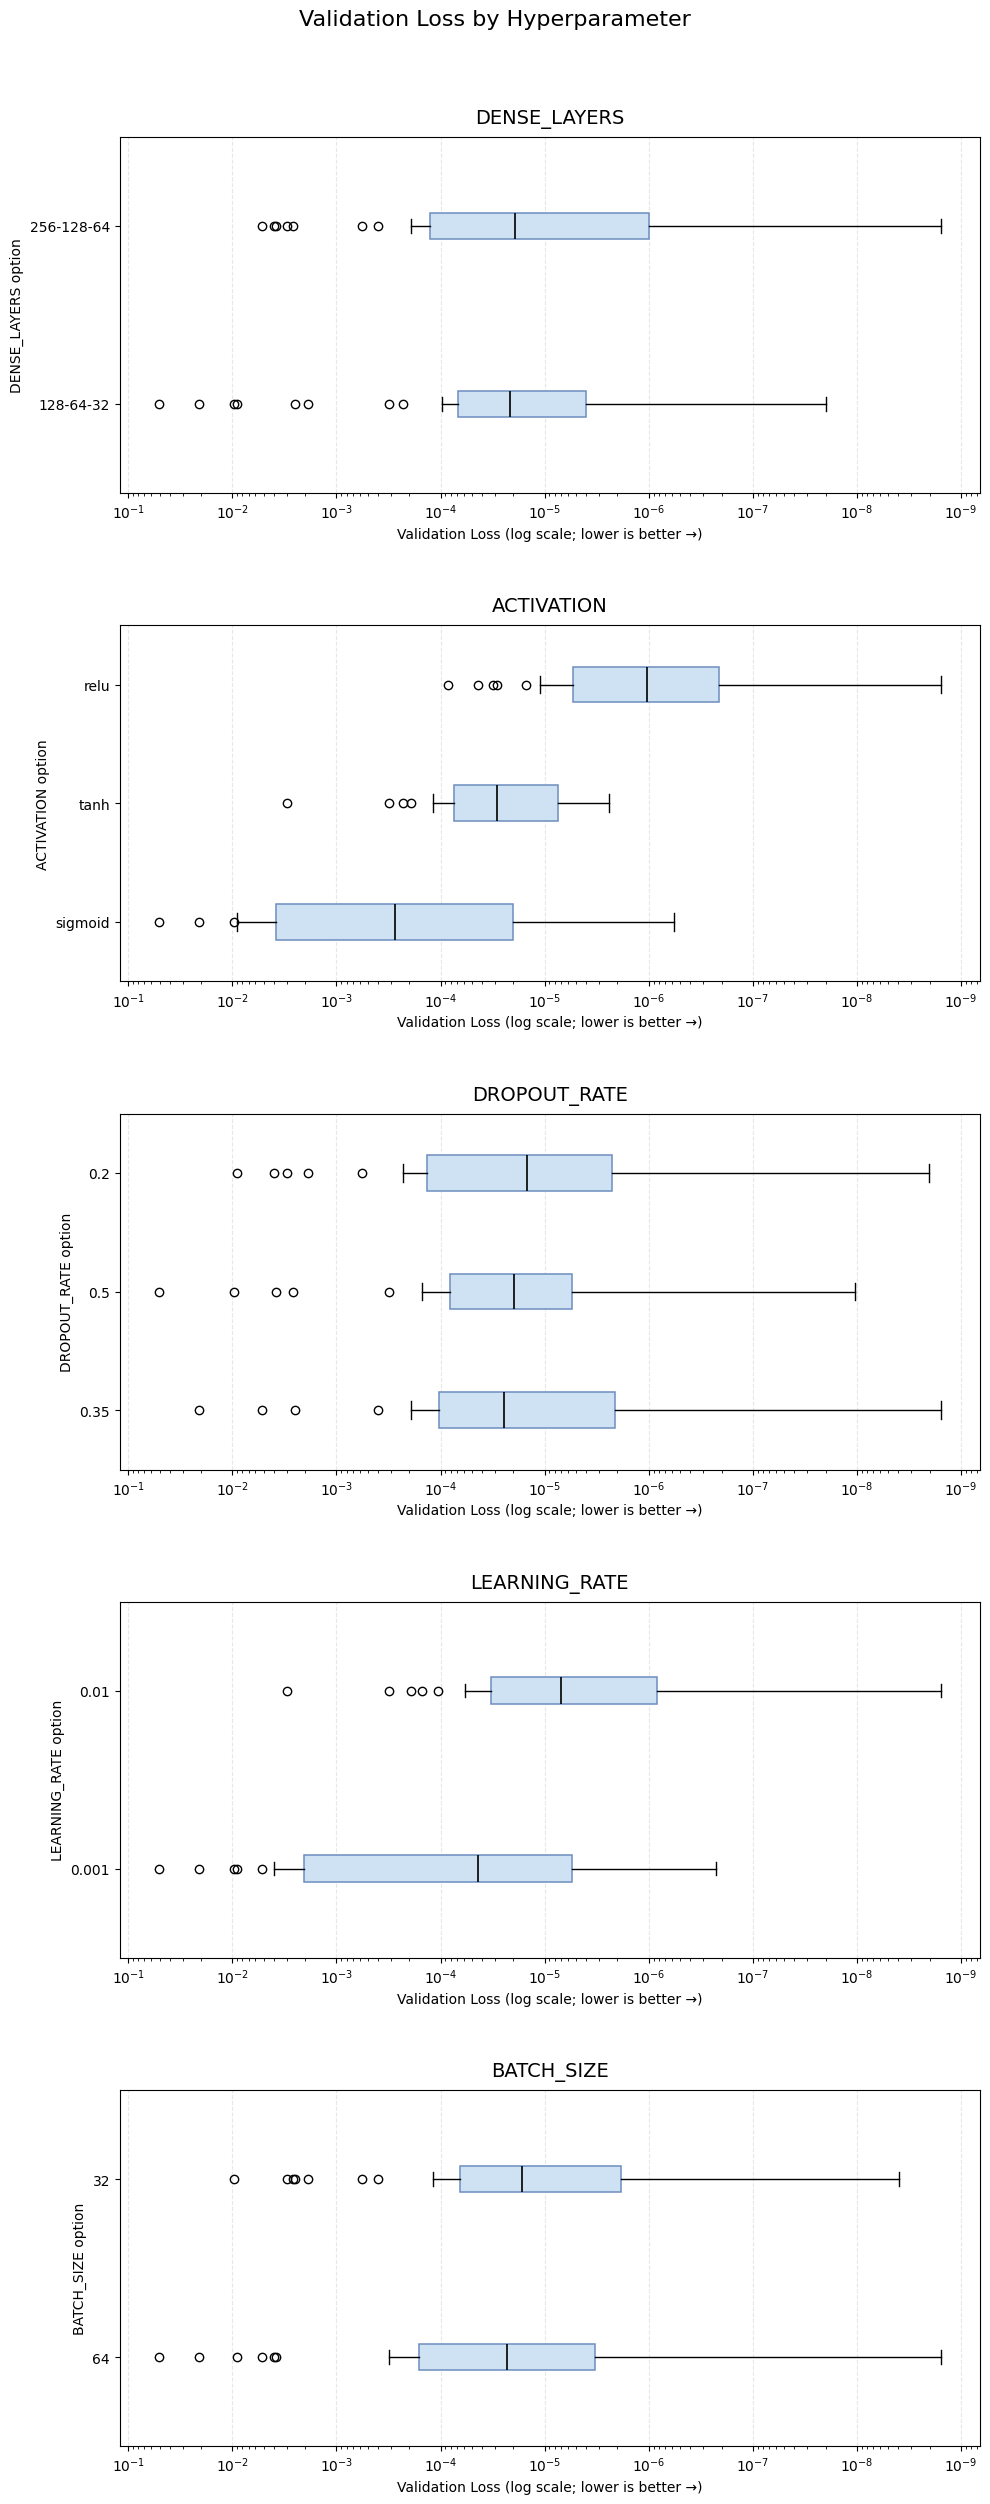

In [4]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
import pandas as pd
import sys
import os

config = AppConfig()
paths = config.get_neural_network_config()
model_performance_path = paths.get('MODEL_PERFORMANCE_PATH')

df = pd.read_csv(model_performance_path)
plot_helper = PlotHelper()
plot_helper.plot_model_val_loss_score(df)
plot_helper.plot_val_loss_by_parameter(df)

<a id="conclusion"></a>
## 5. Conclusion

This notebook successfully demonstrated the process of training a robust hand gesture classifier.

### Key Findings:
-   Through systematic hyperparameter tuning, we identified an optimal set of parameters that yielded a model with high accuracy and strong generalization capabilities.
-   The evaluation of the best model showed excellent performance, with clear separation between classes as seen in the confusion matrix, ROC curves, and dimensionality reduction plots.
-   The final model is well-suited for real-time gesture recognition tasks.

### Limitations and Future Work:
-   **Dataset Diversity**: The current dataset was generated under specific lighting conditions and by a single user. To improve robustness, future work should involve collecting data from multiple users in varied environments.
-   **Dynamic Gestures**: The current model recognizes static gestures. An interesting next step would be to extend the system to recognize dynamic gestures (e.g., swiping, waving) by incorporating temporal information using Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM) networks.
-   **Model Optimization**: For deployment on resource-constrained devices, the model could be optimized using techniques like quantization or pruning to reduce its size and improve inference speed.

The trained model (`gesture_model.h5`) is now ready to be used by the main application for real-time gesture-controlled gaming.

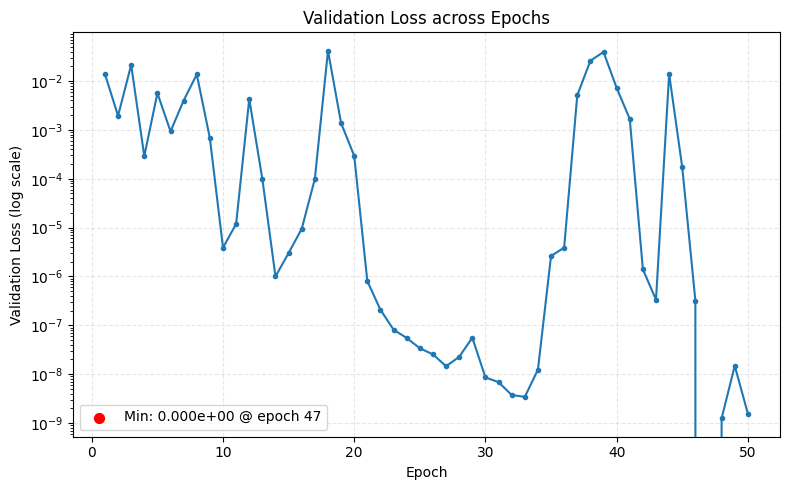

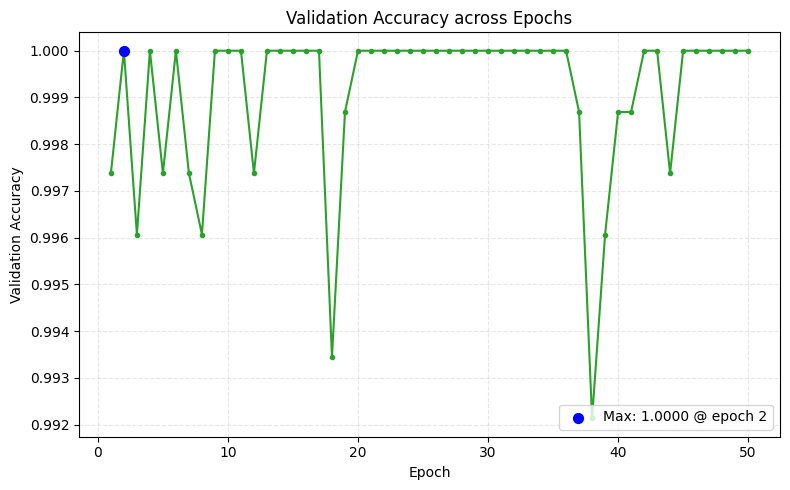

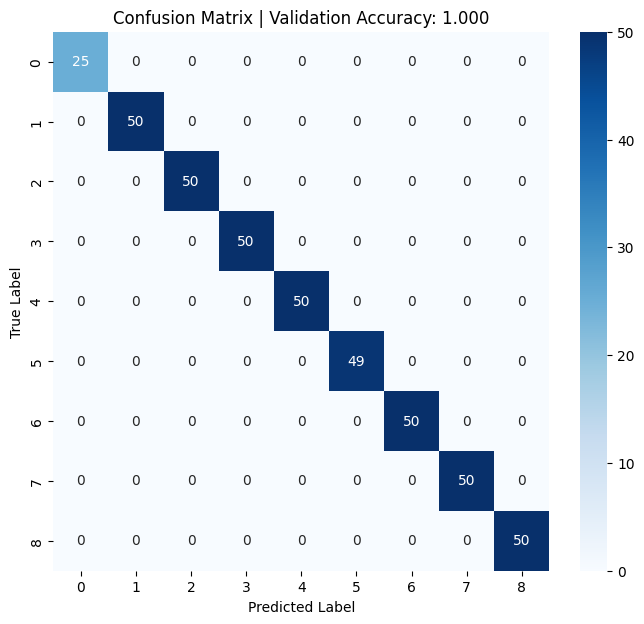

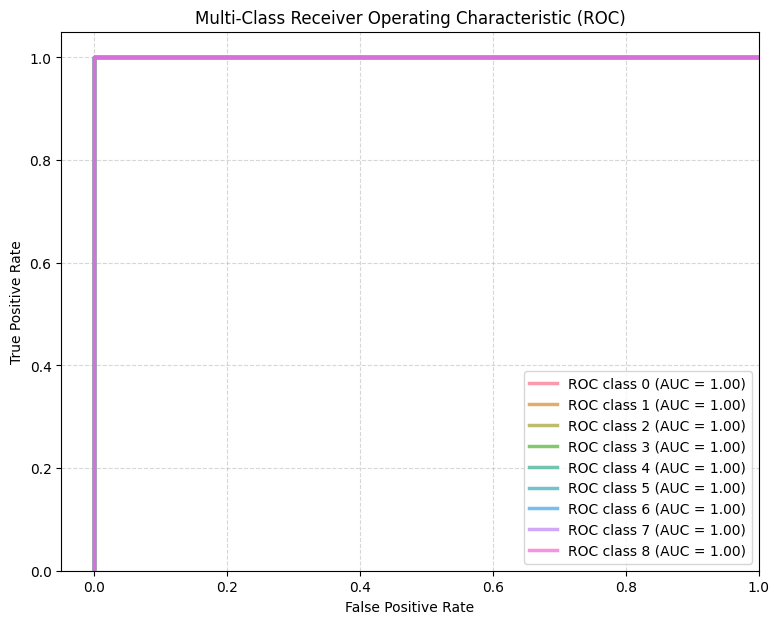

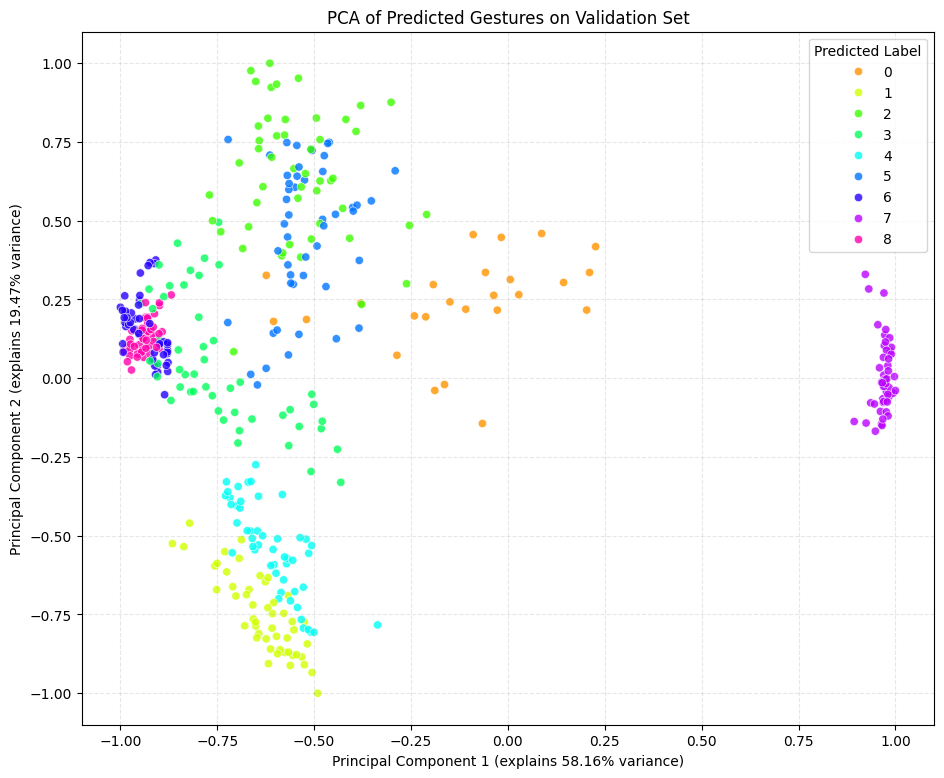

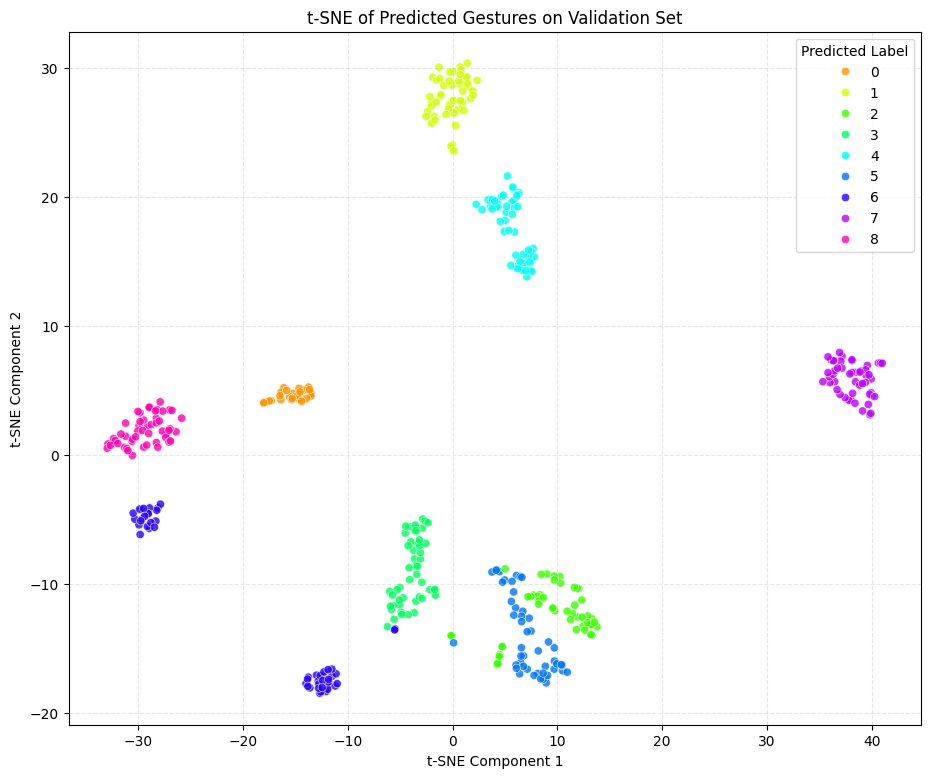

In [1]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

# Resolve paths from config
config = AppConfig()

data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

nn_config = config.get_neural_network_config()
model_path = nn_config.get('MODEL_PATH')
model_performance_path = nn_config.get('MODEL_PERFORMANCE_PATH')


df = pd.read_csv(model_performance_path)
winner = df.sort_values(by=['val_accuracy', 'val_loss'], ascending=[False, True]).iloc[0]
plot_helper = PlotHelper()
plot_helper.plot_val_loss_in_epochs(winner)
plot_helper.plot_val_accuracy_in_epochs(winner)


# Load dataset
df = pd.read_csv(datase_val_path)
df['LANDMARKS'] = df['LANDMARKS'].apply(eval)
X = np.array(df['LANDMARKS'].tolist())
Y = df['GESTURE_ID'].to_numpy()

# Load model and predict
model = tf.keras.models.load_model(model_path)
probs = model.predict(X, verbose=0)
y_pred = np.argmax(probs, axis=1)

# Confusion matrix plot
classes = np.unique(Y)
plot_helper.plot_heatmap(Y, y_pred, classes)

# ROC plot
plot_helper.plot_roc_curve(Y, probs, classes)

# PCA Visualization plot
plot_helper.plot_pca(X, y_pred)

# t-SNE Visualization plot
plot_helper.plot_tsne(X, y_pred)

<a id="evaluation"></a>
## 4. In-Depth Evaluation of the Best Model

Once the best-performing model has been identified from the hyperparameter search, we conduct a more detailed evaluation. This section focuses exclusively on the "winner" model to understand its learning dynamics, classification accuracy, and the structure of its predictions.

### Interpreting the Plots

The following code cell will generate several visualizations to assess the best model:

1.  **Training & Validation Curves (Loss and Accuracy)**: These plots show the model's loss and accuracy on both the training and validation sets over each epoch.
    *   **What to look for**: We want to see both curves converging. If the training loss/accuracy improves but the validation loss/accuracy stagnates or worsens, it's a sign of **overfitting**. A healthy model shows both curves improving and stabilizing.
2.  **Confusion Matrix**: This matrix provides a detailed breakdown of classification performance for each gesture.
    *   **How to read it**: The diagonal elements show the number of correct predictions for each class. Off-diagonal elements show where the model made mistakes (i.e., which gestures it confused with others). A perfect model would have a bright diagonal and dark off-diagonals.
3.  **ROC Curve (Receiver Operating Characteristic)**: This plot illustrates the diagnostic ability of the classifier as its discrimination threshold is varied.
    *   **What it means**: The Area Under the Curve (AUC) is a key metric. An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 represents a model with no discriminative power (equivalent to random guessing). We aim for curves that are pushed towards the top-left corner.
4.  **PCA and t-SNE Plots**: These are dimensionality reduction techniques used to visualize the high-dimensional landmark data in 2D.
    *   **What they show**: The plots show how the model's predictions cluster the data points. Well-separated clusters for each gesture indicate that the model has learned discriminative features and can distinguish between the classes effectively. Overlapping clusters may indicate which gestures are harder for the model to tell apart.